# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [276]:
# Import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.ticker as ticker

from ast import literal_eval
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# For producing visualizations in notebook
%matplotlib inline

!python --version

Python 3.6.3


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [277]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
len_azdias = len(azdias)

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [278]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
num_rows, num_cols = azdias.shape
print('Number of rows: {}'.format(num_rows))
print('Number of columns: {}'.format(num_cols))
azdias.head(5)

Number of rows: 891221
Number of columns: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


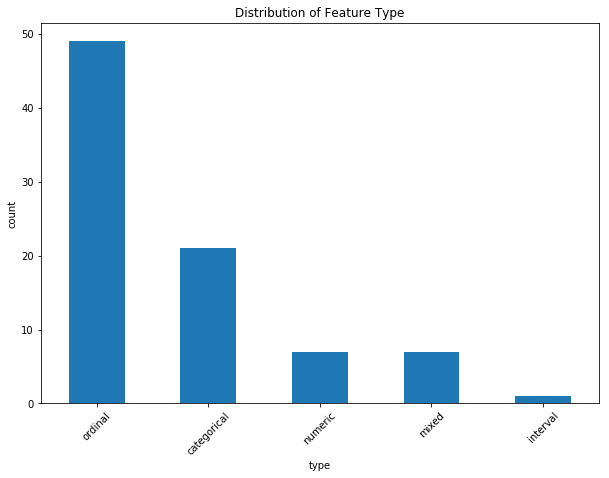

In [279]:
# Take a closer look at Feature Summary file columns
feat_type = feat_info.groupby('type').count()['attribute'].sort_values(ascending = False)
feat_type.plot(kind = 'bar', figsize = (10, 7), rot = 45)
plt.title('Distribution of Feature Type')
plt.ylabel('count')
plt.show()

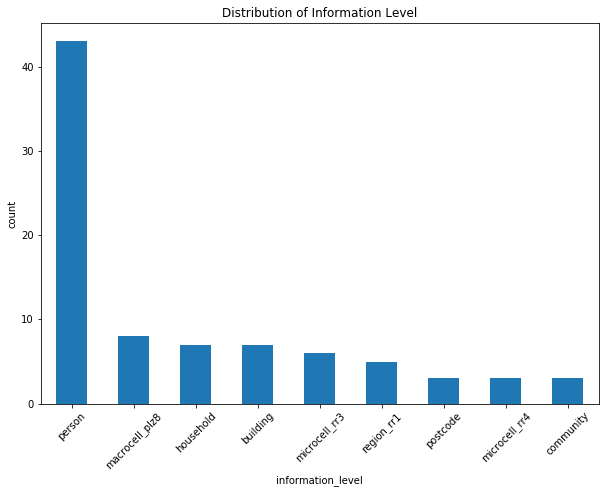

In [280]:
feat_inform = feat_info.groupby('information_level').count()['attribute'].sort_values(ascending = False)
feat_inform.plot(kind = 'bar', figsize = (10, 7), rot = 45)
plt.title('Distribution of Information Level')
plt.ylabel('count')
plt.show()

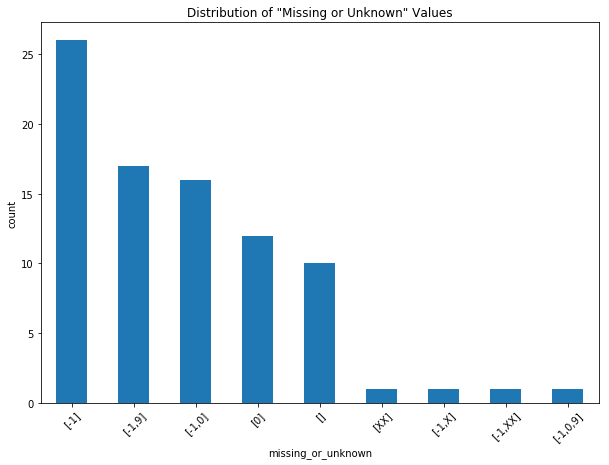

In [281]:
feat_miss_unk = feat_info.groupby('missing_or_unknown').count()['attribute'].sort_values(ascending = False)
feat_miss_unk.plot(kind = 'bar', figsize = (10, 7), rot = 45)
plt.title('Distribution of "Missing or Unknown" Values')
plt.ylabel('count')
plt.show()

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [282]:
# Identify missing or unknown data values and convert them to NaNs.
# Some cleanup 
for i, column in enumerate(azdias.columns):
    str_n = feat_info['missing_or_unknown'].iloc[i]
    if i in [57, 58, 59]:  # to accomodate for [*X] unknown values
        list_n = str_n[1: -1].split(',')
    else:
        list_n = literal_eval(str_n)
    for j in list_n:
        azdias[column].replace(j, np.NaN, inplace = True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [283]:
# Perform an assessment of how much missing data there is in each column of the dataset.
null_count_col = azdias.isnull().sum()
null_perc_col = null_count_col / len(azdias) * 100

num_cols_missing = len(null_count_col[null_count_col != 0])
perc_cols_missing = num_cols_missing / len(null_count_col) * 100
print('{}% of the features in the dataset contain one or more missing values ({} out of the {} total features).'.format(round(perc_cols_missing, 2), num_cols_missing, num_cols))

71.76% of the features in the dataset contain one or more missing values (61 out of the 85 total features).


Text(0,0.5,'Number of Attributes (Features)')

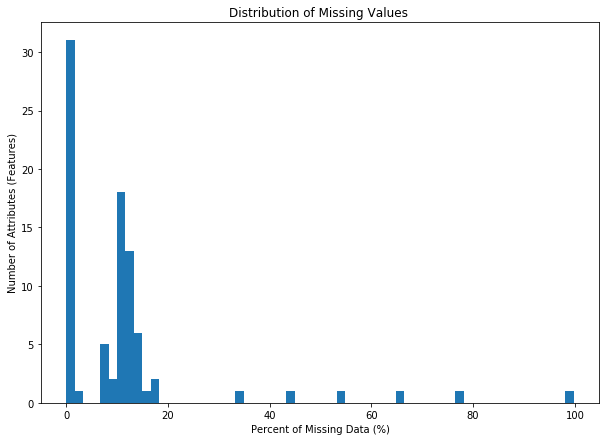

In [284]:
# Investigate patterns in the amount of missing data in each column.
null_perc_col.plot(kind = 'hist', figsize = (10, 7), bins = 60,
                                            title = 'Distribution of Missing Values ')       
plt.xlabel('Percent of Missing Data (%)')
plt.ylabel('Number of Attributes (Features)')

**In this plot, you can see that there are a few features that are outliers in terms of the proportion of values that are missing, let's see which columns have more than 20% missing values.**

In [285]:
# List the features with missing values > 20% 
null_perc_col[null_perc_col > 20]

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [286]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1, inplace = True)

In [287]:
# Check the structure of the data after dropping the outlier columns
# Original num of rows and columns
#print('Original number of rows: {}'.format(num_rows))
print('Original number of columns: {}'.format(num_cols))

# New num of rows and columns
new_num_rows, new_num_cols = azdias.shape
#print('Number of rows: {}'.format(new_num_rows)) # to make sure same num of rows still
print('New number of columns: {}'.format(new_num_cols))

Original number of columns: 85
New number of columns: 79


In [288]:
# Remove the outlier columns from feat_info as well
drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
for col in drop_columns:
    drop_index = feat_info[feat_info['attribute'] == col].index[0]
    feat_info.drop(drop_index, axis = 0, inplace = True)

**For the *remaining features*, let's look for any patterns in which columns have, or share, missing data, starting with looking at information level.**

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4959: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  other.columns, how=join, level=level, return_indexers=True)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

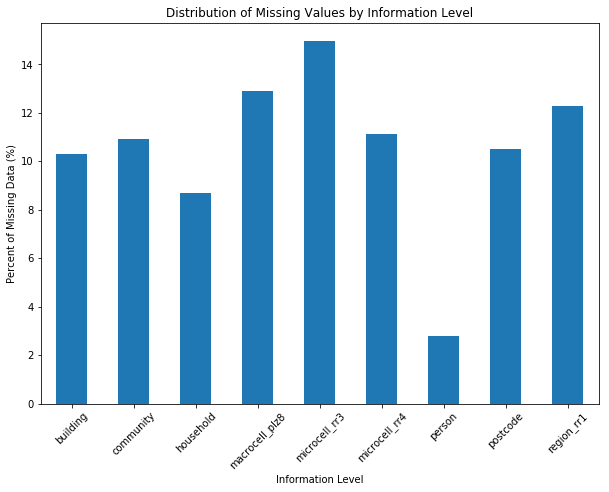

In [289]:
# See if any patterns just by information level
feat_info_joined = feat_info.set_index('attribute').join(pd.DataFrame(null_count_col))
missing_by_info = (feat_info_joined.groupby('information_level').sum()/(feat_info_joined.groupby('information_level').count()
                                                                   *len(azdias))*100) 
missing_by_info[0].plot(kind = 'bar', figsize = (10, 7), title = 'Distribution of Missing Values by Information Level')
plt.ylabel('Percent of Missing Data (%)')
plt.xlabel('Information Level')
plt.xticks(rotation = 45)

**From this plot above, it appears that there are more missing values in features pertaining to *housing surroundings/characteristics* (as compared to the more granular features such as person-level features) such as:**
* micro/macro-cell features (e.g. N-family member houses, life stage typology)
* region (e.g. neighborhood topology, movement patterns) and 
* community (e.g. size, share of unemployment in community) 
    
**Let's next take a closer look at how many features share the same number of missing values to see if there is a pattern.** 

In [290]:
# New null counts per feature after dropping the outlier features
null_count_col_new = azdias.isnull().sum()
df_null_col = pd.DataFrame({'attribute': null_count_col_new.index, 'num_nulls': null_count_col_new.values})

[Text(0,0.5,'Number of Missing Values'),
 Text(0.5,0,'Number of Features'),
 Text(0.5,1,'Number of Features by Missing Value Counts')]

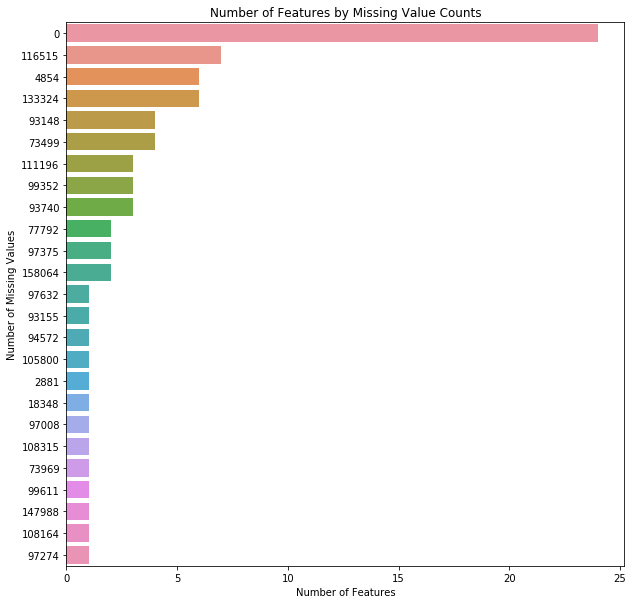

In [291]:
# Let's play with seaborn
plt.figure(figsize = (10,10))
val_cnts = df_null_col['num_nulls'].value_counts().index
ax = sns.countplot(y = 'num_nulls' , data = df_null_col, order = val_cnts)
ax.set(xlabel = 'Number of Features', ylabel = 'Number of Missing Values', title = 'Number of Features by Missing Value Counts')

**This plot above shows that there are 24 features (attributes) that have no missing values, as well as (interestingly enough) varying numbers of features that share same numbers of missing values.  Let's look more granularly to see if there is any pattern between the specific features and common missing value counts.**

[Text(0,0.5,'Features'),
 Text(0.5,0,'Number of Missing Values'),
 Text(0.5,1,'Distribution of Shared Missing Values Across Features')]

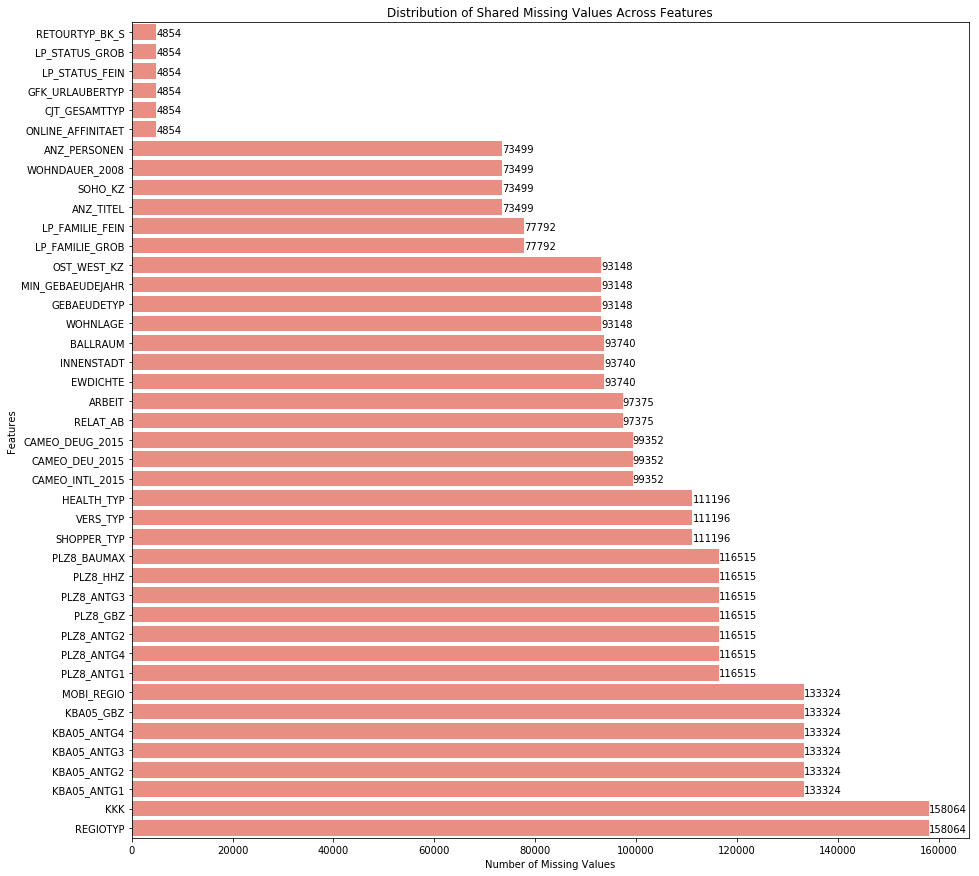

In [292]:
# Exclude features with NO missing values and sort for plotting
missing_shared = df_null_col.loc[df_null_col['num_nulls'] != 0]
missing_shared.reset_index(drop = True, inplace = True)
shared_sorted = missing_shared.sort_values('num_nulls')

# Exclude features with UNIQUE num of missing values since we only want features that share SAME num of nulls
grouped = shared_sorted.groupby('num_nulls').filter(lambda x: len(x) > 1)
plt.figure(figsize = (15,15))
shared_plt = sns.barplot(y = 'attribute', x = 'num_nulls', data = grouped, color = 'salmon')
for p in shared_plt.patches:
    width = p.get_width()
    shared_plt.text(width,
            p.get_y() + p.get_height()/2 + 0.2,
            '{:.0f}'.format(width),
            ha="left")
shared_plt.set(xlabel = 'Number of Missing Values', ylabel = 'Features', title = "Distribution of Shared Missing Values Across Features")

#### Discussion 1.1.2: Assess Missing Data in Each Column
From the original dataset, a majority (almost 72%) of the features contained missing data, and six particular features (**AGER_TYP**, **GEBURTSJAHR**, **TITEL_KZ**, **ALTER_HH**, **KK_KUNDENTYP**, **KBA05_BAUMAX**) each contained over 20% of missing values.  As a result, these six features have been removed from the dataset. 

When looking to see if there were any patterns in missing values from the remaining features, I looked at the following:
1. Information Level
    * It appeared that there were more missing values in features pertaining to **housing surroundings/characteristics** such as micro/macro-cell features (e.g. N-family member houses, life stage typology), region (e.g. neighborhood topology, movement patterns), and community (e.g. size, share of unemployment in community), as compared to the more granular features in the data set such as person-level features.
2. Shared missing data 
    * Going one step further, it appeared that there were varying numbers of features that interestingly enough shared the *same exact* numbers of missing values.  When looking at these specific groupings, it appeared that features that shared the same **level of measurement** also shared the same number of missing values.  For example, the majority of PLZ8 macro-cell features in the data set (PLZ8* in the plot above) all shared the same number of missing values, similarly the majority of RR3 micro-cell features (KBA05* in the plot above) in the dataset also reflected the same, etc.. 



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [293]:
# How much data is missing in each row of the dataset?
null_count_row = azdias.isnull().sum(axis = 1)
null_perc_row = null_count_row / len(azdias.columns) * 100

# Calculate ratio
num_row_missing = len(null_count_row[null_count_row > 0])
perc_row_missing = num_row_missing / len(null_count_row) * 100
print('{}% of rows in the dataset contain one or more missing values ({} out of {} total rows).'.format(round(perc_row_missing, 2), num_row_missing, num_rows))


30.07% of rows in the dataset contain one or more missing values (268012 out of 891221 total rows).


Text(0,0.5,'Number of Rows')

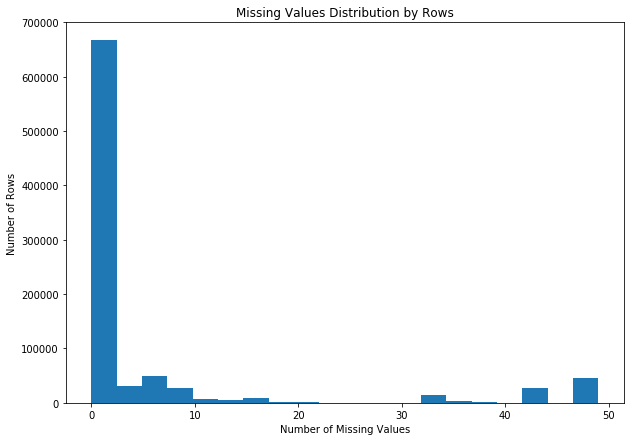

In [294]:
null_count_row.plot(kind = 'hist', figsize = (10, 7), bins = 20,
                                            title = 'Missing Values Distribution by Rows')       
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')

**There are number of rows that have more than 10 missing values, so let's set a threshold to 10 and examine the distributions.**

In [295]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
# Using threshold = 10 missing values
less_missing = azdias[azdias.isnull().sum(axis = 1) <= 10].reset_index(drop = True)
more_missing = azdias[azdias.isnull().sum(axis = 1) > 10].reset_index(drop = True)

In [296]:
# Function that compare the distribution of values for at least five columns where there are no or few missing values, 
# between the two subsets.
def compare_distribs(col_name):
    plt.figure(figsize = (12,4))
    plt.subplot(121)
    ax = sns.countplot(x = col_name, data = less_missing)
    plt.title("<= 10 Missing Values")
    plt.subplot(122)
    ax = sns.countplot(x = col_name, data = more_missing)
    plt.title("> 10 Missing Values")

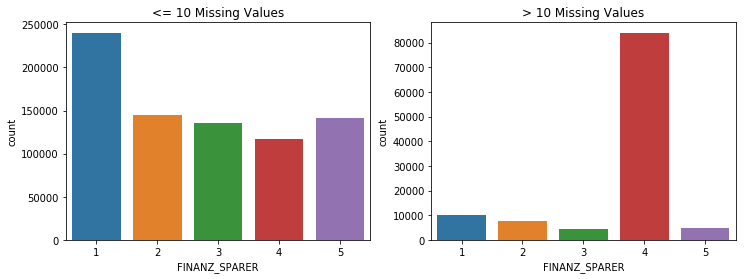

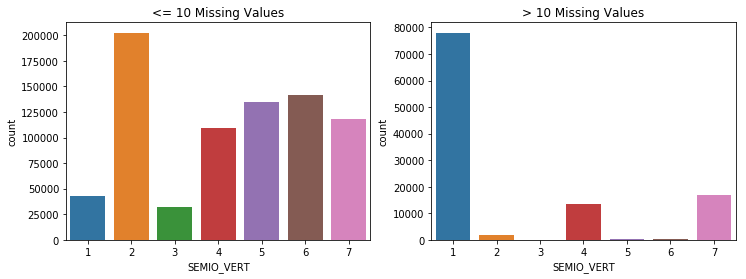

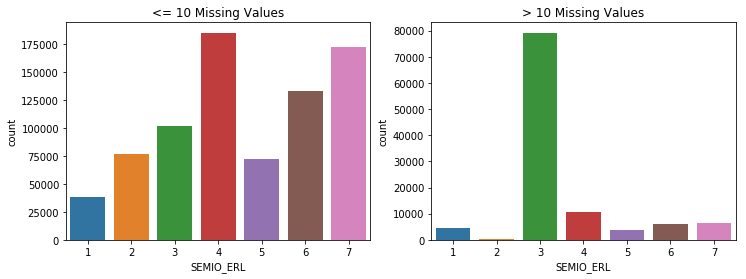

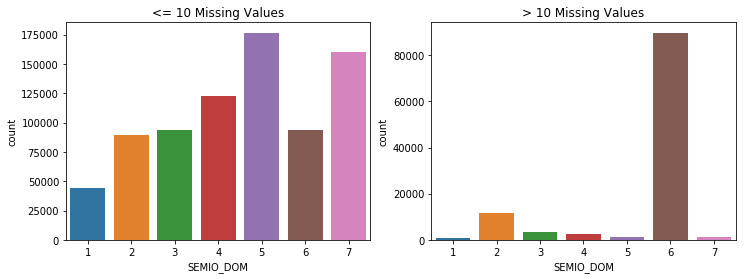

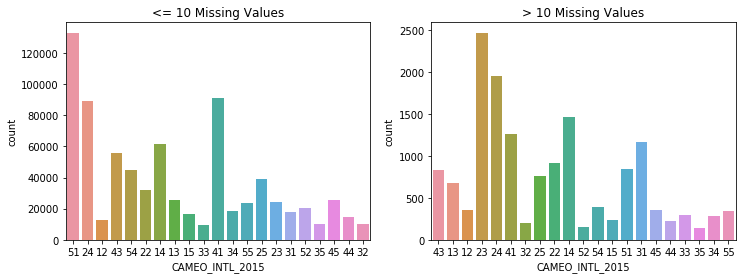

In [297]:
# Columns that are not missing data (or are missing very little data)
cols_few_null = list(less_missing.columns)
random.shuffle(cols_few_null)

# Prints plots that compare distributions for 5 random columns that have few nulls
for i in cols_few_null[:5]:
    compare_distribs(i)

#### Discussion 1.1.3: Assess Missing Data in Each Row

**About a third of the rows in the data set contained missing values. Looking at the distribution of missing values by number of rows, there were a number of rows that had more than 10 missing values and so I decided to divide the data into two subsets using the missing value threshold of n=10. Using this threshold and looking at the compared distribution plots on columns that are not missing data (or are missing very little data) above, you can see that there are indeed differences between the rows that have a lesser number of missing values and a large number of missing values for various columns.**

**These said columns will be treated separately rather than dropped.** 


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [298]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [299]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
categorical_features = list(feat_info[feat_info['type'] == 'categorical']['attribute'].values)
print('Categorical features and their unique values:\n')
_ = azdias[categorical_features].apply(lambda x: print(x.name, ':', x.unique()))

Categorical features and their unique values:

ANREDE_KZ : [1 2]
CJT_GESAMTTYP : [2.0 5.0 3.0 4.0 1.0 6.0 nan]
FINANZTYP : [4 1 6 5 2 3]
GFK_URLAUBERTYP : [10.0 1.0 5.0 12.0 9.0 3.0 8.0 11.0 4.0 2.0 7.0 6.0 nan]
GREEN_AVANTGARDE : [0 1]
LP_FAMILIE_FEIN : [2.0 5.0 1.0 nan 10.0 7.0 11.0 3.0 8.0 4.0 6.0 9.0]
LP_FAMILIE_GROB : [2.0 3.0 1.0 nan 5.0 4.0]
LP_STATUS_FEIN : [1.0 2.0 3.0 9.0 4.0 10.0 5.0 8.0 6.0 7.0 nan]
LP_STATUS_GROB : [1.0 2.0 4.0 5.0 3.0 nan]
NATIONALITAET_KZ : [nan 1.0 3.0 2.0]
SHOPPER_TYP : [nan 3.0 2.0 1.0 0.0]
SOHO_KZ : [nan 1.0 0.0]
VERS_TYP : [nan 2.0 1.0]
ZABEOTYP : [3 5 4 1 6 2]
GEBAEUDETYP : [nan 8.0 1.0 3.0 2.0 6.0 4.0 5.0]
OST_WEST_KZ : [nan 'W' 'O']
CAMEO_DEUG_2015 : [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 : [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [300]:
# Re-encode categorical variable(s) to be kept in the analysis
less_missing = pd.get_dummies(less_missing, columns = ['CJT_GESAMTTYP','FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                                               'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'OST_WEST_KZ'])

# Dropping multi-level categoricals with more than 6 distinct values
azdias_encoded = less_missing.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis = 1)


In [301]:
azdias_encoded
num_rows_enc, num_cols_enc = azdias_encoded.shape
print('Number of columns: {}'.format(num_cols_enc))

Number of columns: 102


#### Discussion 1.2.1: Re-Encode Categorical Features

**There were a total of 18 categorical features in the data set:**
* **4 binary categoricals that took on numeric values - kept as is**
* **1 binary categorical that took on non-numeric values (OST_WEST_KZ) - kept/re-encoded with dummy variable**
* **13 multi-level categoricals - kept/re-encoded 7 of these (that had at most 6 distinct values) with dummy variables, dropped the remaining 6 features (that had more than 6 distinct values)**
    - **Kept/re-encoded columns:** 'CJT_GESAMTTYP','FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP'
    - **Dropped columns:** 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'
    
**After feature selection/engineering of these categoricals, we are now left with 102 columns in the dataset.** 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [302]:
# Features of 'Mixed' type
list(feat_info[feat_info['type'] == 'mixed']['attribute'].values)

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

**Looking at the feature *PRAEGENDE_JUGENDJAHRE*:** 

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [303]:
# Engineer two new variables, decade and movement, for 'PRAEGENDE_JUGENDJAHRE'
# For movement:
#    Mainstream = 1
#    Avantgarde = 0
full_mapping = pd.DataFrame({-1: [np.nan, np.nan],
                          0: [np.nan, np.nan],
                          1: [40, 1],
                          2: [40, 0],
                          3: [50, 1],
                          4: [50, 0],
                          5: [60, 1],
                          6: [60, 0],
                          7: [60, 0],
                          8: [70, 1],
                          9: [70, 0],
                          10: [80, 1],
                          11: [80, 0],
                          12: [80, 1],
                          13: [80, 0],
                          14: [90, 1],
                          15: [90, 0]}).T

# Create column that encodes decade
decade_mapping = full_mapping[0].to_dict()
azdias_encoded['DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

# Create column that encodes movement 
movement_mapping = full_mapping[1].to_dict()
azdias_encoded['MOVEMENT'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)

**Looking at the feature *CAMEO_INTL_2015*:**

German CAMEO: Wealth / Life Stage Typology, mapped to international code

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [304]:
# Engineer two new variables, wealth and life stage, for 'CAMEO_INTL_2015'
# We do this by breaking up the two-digit codes by their 'tens'-place and 'ones'-place digits 
# into two new ordinal variables
azdias_encoded['WEALTH'] = pd.to_numeric(azdias_encoded['CAMEO_INTL_2015']) // 10
azdias_encoded['LIFE_STAGE'] = pd.to_numeric(azdias_encoded['CAMEO_INTL_2015']) % 10

#### Discussion 1.2.2: Engineer Mixed-Type Features

**There were a total of six 'mixed' features in the data set.  Given that the features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were both multi-dimensional, I performed feature engineering on both by splitting each into two new features:**
* *PRAEGENDE_JUGENDJAHRE*: **created two new variables, decade and movement**
* *CAMEO_INTL_2015*: **created two new variables, wealth and life stage**

**The other four features were all one dimensional, therefore I kept those as is.**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [305]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [306]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# Dropping the original PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns from the dataset
azdias_encoded.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace = True)

In [307]:
num_rows_enc, num_cols_enc = azdias_encoded.shape
print('New number of columns: {}'.format(num_cols_enc))

New number of columns: 104


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [308]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
    
    # execute all main cleaning steps:
    # Identify missing or unknown data values and convert them to NaNs.
    for i, column in enumerate(df.columns):
        str_n = feat_info['missing_or_unknown'].iloc[i]
        if i in [57, 58, 59]:  # to accomodate for [*X] unknown values
            list_n = str_n[1: -1].split(',')
        else:
            list_n = literal_eval(str_n)
        for j in list_n:
            df[column].replace(j, np.NaN, inplace = True)

    # Remove the outlier columns from the dataset
    df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1, inplace = True)
            
    # Divide the data into two subsets based on the number of missing values in each row.
    # Using threshold = 10 missing values
    less_missing_df = df[df.isnull().sum(axis = 1) <= 10].reset_index(drop = True)

    # Re-encode categorical variable(s) to be kept in the analysis
    less_missing_df = pd.get_dummies(less_missing_df, columns = ['CJT_GESAMTTYP','FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                                                   'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'OST_WEST_KZ'])

    # Dropping multi-level categoricals with more than 6 distinct values
    df = less_missing_df.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis = 1)

    # Engineer two new variables, decade and movement, for 'PRAEGENDE_JUGENDJAHRE'
    # For movement:
    #    Mainstream = 1
    #    Avantgarde = 0
    full_mapping = pd.DataFrame({-1: [np.nan, np.nan],
                              0: [np.nan, np.nan],
                              1: [40, 1],
                              2: [40, 0],
                              3: [50, 1],
                              4: [50, 0],
                              5: [60, 1],
                              6: [60, 0],
                              7: [60, 0],
                              8: [70, 1],
                              9: [70, 0],
                              10: [80, 1],
                              11: [80, 0],
                              12: [80, 1],
                              13: [80, 0],
                              14: [90, 1],
                              15: [90, 0]}).T

    # Create column that encodes decade
    decade_mapping = full_mapping[0].to_dict()
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

    # Create column that encodes movement 
    movement_mapping = full_mapping[1].to_dict()
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)


    # Engineer two new variables, wealth and life stage, for 'CAMEO_INTL_2015'
    # We do this by breaking up the two-digit codes by their 'tens'-place and 'ones'-place digits 
    # into two new ordinal variables
    df['WEALTH'] = pd.to_numeric(df['CAMEO_INTL_2015']) // 10
    df['LIFE_STAGE'] = pd.to_numeric(df['CAMEO_INTL_2015']) % 10

    # Drop the original PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns from the dataset
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace = True)

    # Return the cleaned dataframe.
    return df

In [309]:
# To check clean_data function above:
# Load in the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Run azdias through clean data and make sure the columns are the same
azdias = clean_data(azdias)
feature_names = list(azdias.columns)
rows_enc, cols_enc = azdias.shape
print('Number of columns: {}'.format(cols_enc))

Number of columns: 104


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [310]:
# Apply Imputer to replace all missing values
# Apply feature scaling to the general population demographics data (azdias)
imputer = Imputer(missing_values = float("NaN"), strategy = "mean", axis = 1, copy = False)
scaler = StandardScaler()
azdias[azdias.columns] = scaler.fit_transform(imputer.fit_transform(azdias))

In [311]:
# Check that all 'NAN's are transformed
azdias.isnull().sum().sum()

0

In [312]:
# Check StandardScaler
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
count,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,...,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05
mean,-4.521080e-17,4.519714e-17,1.012780e-16,7.527544e-17,8.963834e-17,1.339657e-16,9.701560e-17,-1.161965e-16,-8.288040e-17,3.880624e-16,...,-5.663190e-17,1.210418e-17,-1.741399e-17,-2.975497e-17,6.870876e-17,-1.216793e-16,1.222843e-15,3.134883e-17,6.164480e-16,2.724215e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.023329e+00,-1.043411e+00,-1.488140e+00,-1.151087e+00,-1.771610e+00,-1.247812e+00,-1.172510e+00,-1.532818e+00,-5.311987e-01,-4.288664e-01,...,-7.412825e-01,-5.944357e-01,-3.369173e-01,-3.134834e-01,-5.187691e-01,-1.927640e+00,-3.045877e+00,-3.375977e-01,-1.075618e+00,-8.806844e-01
25%,-4.808505e-01,-1.043411e+00,-7.624505e-01,-1.151087e+00,-1.045251e+00,-1.247812e+00,-1.172510e+00,-8.178947e-01,-5.311987e-01,-2.483434e-01,...,-7.412825e-01,-5.944357e-01,-3.369173e-01,-3.134834e-01,-5.187691e-01,5.187691e-01,-7.109739e-01,-1.403664e-01,-6.251444e-01,-8.806844e-01
50%,6.162847e-02,9.583948e-01,-3.676105e-02,1.939963e-01,4.074683e-01,1.097306e-01,-4.549831e-01,-1.029710e-01,-5.311987e-01,-2.483434e-01,...,-7.412825e-01,-5.944357e-01,-3.369173e-01,-3.134834e-01,-5.187691e-01,5.187691e-01,-1.041965e-01,-1.403664e-01,2.758023e-01,6.182818e-03
75%,6.041074e-01,9.583948e-01,6.889284e-01,8.665379e-01,1.133828e+00,7.885020e-01,9.800714e-01,6.119528e-01,-5.311987e-01,-6.782041e-02,...,1.349013e+00,1.682268e+00,-3.369173e-01,-3.134834e-01,-5.187691e-01,5.187691e-01,1.109358e+00,-1.403664e-01,7.262757e-01,4.496164e-01
max,2.278547e+01,9.583948e-01,1.414618e+00,1.539080e+00,1.133828e+00,1.467273e+00,1.697599e+00,1.326876e+00,1.882535e+00,7.903695e+00,...,1.349013e+00,1.682268e+00,2.968088e+00,3.189962e+00,1.927640e+00,5.187691e-01,1.109358e+00,9.104322e+00,1.919113e+01,1.906935e+01


### Discussion 2.1: Apply Feature Scaling

**I applied an Imputer to replace all missing values using the mean, then scaled the data via StandardScaler. As far as effects/impact, imputing the missing values here shouldn't have a significant impact given that the rows that had large counts of missing values in the dataset were dropped earlier on.**

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [313]:
# Apply PCA to the data.
pca = PCA()
pca_model = pca.fit_transform(azdias)

In [314]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width = 0)
    ax.yaxis.set_tick_params(width = 2, length = 12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

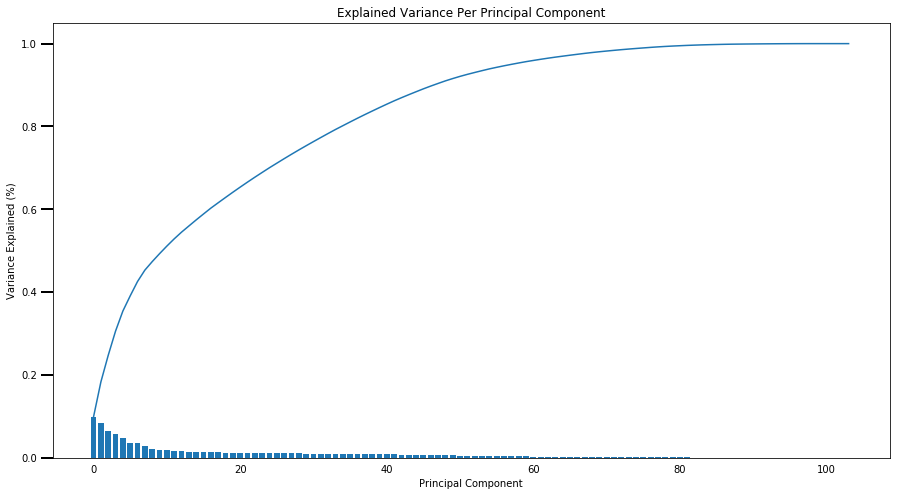

In [315]:
scree_plot(pca)

In [316]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(75)
pca_model = pca.fit_transform(azdias)

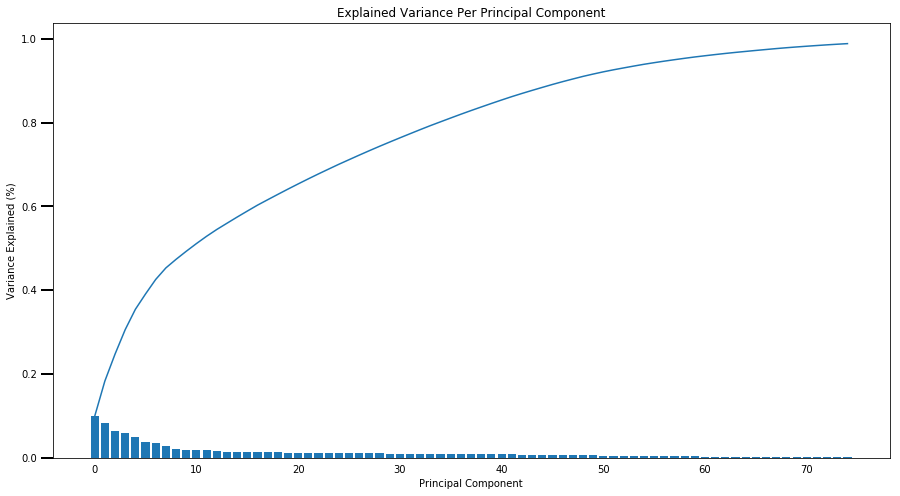

In [317]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

**The first scree plot above shows the beginning of a "leveling off" in explained variance at around 75 components; therefore I chose to retain 75 components for clustering which represent at least 95% of the cumulative variance.**

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [318]:
def pca_weights(num_components):
    components = pd.DataFrame(np.round(pca.components_[num_components - 1: num_components], 4), columns = azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending = False)
    components = components.T
    print('Top five (+) weighted features:\n', components.head(5))
    print('\nTop five (-) weighted features:\n', components.tail(5))
    return components

In [319]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca1 = pca_weights(1)

Top five (+) weighted features:
                        Weights
FINANZ_SPARER           0.2639
SEMIO_REL               0.2326
SEMIO_PFLICHT           0.2277
SEMIO_TRADV             0.2090
FINANZ_UNAUFFAELLIGER   0.2034

Top five (-) weighted features:
                    Weights
ZABEOTYP_3         -0.1582
SEMIO_LUST         -0.1582
SEMIO_ERL          -0.1802
FINANZ_MINIMALIST  -0.2253
FINANZ_VORSORGER   -0.2336


In [320]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca2 = pca_weights(2)

Top five (+) weighted features:
              Weights
MOBI_REGIO    0.2350
KBA05_GBZ     0.2297
KBA05_ANTG1   0.2296
KBA05_ANTG2   0.1930
KBA05_ANTG4   0.1866

Top five (-) weighted features:
                     Weights
EWDICHTE            -0.1338
ZABEOTYP_3          -0.1399
LP_STATUS_GROB_1.0  -0.1558
HH_EINKOMMEN_SCORE  -0.1716
FINANZ_HAUSBAUER    -0.2042


In [321]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca3 = pca_weights(3)

Top five (+) weighted features:
             Weights
ANREDE_KZ    0.3157
SEMIO_KAEM   0.2980
SEMIO_DOM    0.2584
SEMIO_KRIT   0.2575
SEMIO_ERL    0.1744

Top five (-) weighted features:
                    Weights
FINANZ_MINIMALIST  -0.1344
SEMIO_FAM          -0.2216
SEMIO_KULT         -0.2243
SEMIO_SOZ          -0.2398
SEMIO_VERT         -0.2850


### Discussion 2.3: Interpret Principal Components

**First Component**

**For the first component, we see a hybrid between financial and personality topologies (all person-level features) that complement one another. It makes sense that religious people have a tendancy to feel/be more dutiful (weights with same sign), and likewise people that are more event-oriented tend to be more prepared (again weights with same sign). Notice that low financial interest is negatively correlated with money-saving which also makese sense; since interest is simply the cost of borrowing money, the more money you save, the lower the financial interest.** 

Top positively correlated features for PC1:
* Financial typology - money-saver (**FINANZ_SPARER**) ~26.4%
* Personality typology - religious (**SEMIO_REL**) ~23.3%
* Personality typology - dutiful (**SEMIO_PFLICHT**) ~22.8%

Top negatively correlated features for PC1:
* Financial typology - be prepared (**FINANZ_VORSORGER**) ~ -23.4%
* Financial typology - low financial interest (**FINANZ_MINIMALIST**) ~ -22.5%
* Personality typology - event-oriented (**SEMIO_ERL**) ~ -18.0%

---------
**Second Component**

**For the second component, the strong correlations pertain to a variety of different feature levels i.e. region, micro-cell, person and household-level features. It makes sense that the more frequent a person/family moves from place to place (movement patterns), the less likely they are to actually fit into the home ownership category when considering financial topology as it is very costly to move. Complementing this, given the high expense of frequent moving, the negative correlation with low-income earners/estimated household net income also makes sense since it's unlikely that people with lower incomes can afford to move frequently.  Finally, people with lower (individual/household) incomes tend to not be able to afford moving into a place within a larger housing complex/micro-cell.**

Top positively correlated features for PC2:
* Movement patterns (**MOBI_REGIO**) ~23.5%
* Number of buildings in the microcell (**KBA05_GBZ**) ~23.0%
* Number of 1-2 family houses in the microcell (**KBA05_ANTG1**) ~23.0%

Top negatively correlated features for PC2:
* Financial typology - home ownership (**FINANZ_HAUSBAUER**) ~ -20.4%
* Estimated household net income (**HH_EINKOMMEN_SCORE**) ~ -17.2%
* Social status - low-income earners (**LP_STATUS_GROB_1.0**) ~ -15.6%

----
**Third Component**

**For the third component, gender and personality traits reflect the highest weights. The more dominant-minded a person is, the more likely they are to be combative. Likewise, the less socially-minded someone is, the less likely they are to be culturely-minded as well. It then makes sense that the more combative one is, the less likely they are to be dreamful and socially-minded.  In summary, it's natural that an individual's personality and attitude go hand-in-hand.** 

Top positively correlated features for PC3:
* Gender (**ANREDE_KZ**) ~31.6%
* Personality typology - combative attitude (**SEMIO_KAEM**) ~30.0%
* Personality typology - dominant-minded (**SEMIO_DOM**) ~25.8%

Top negatively correlated features for PC3:
* Personality typology - dreamful (**SEMIO_VERT**) ~ -28.5%
* Personality typology - socially-minded (**SEMIO_SOZ**) ~ -24.0%
* Personality typology - cultural-minded (**SEMIO_KULT**) ~ -22.4%

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [324]:
def get_scores(data, k):
    kmeans = KMeans(k)
    km_model = kmeans.fit(data)
    return abs(km_model.score(data))

In [325]:
# Over a number of different cluster counts, run k-means clustering on the data and 
#   compute the average within-cluster distances.
scores = []
centroids = [1, 4, 8] + list(np.arange(10, 31, 5)) 
for i in centroids:
    scores.append(get_scores(pca_model, i))  
    

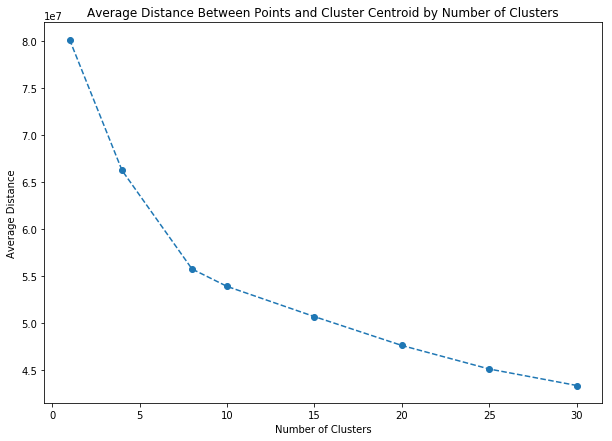

In [326]:
# Investigate the change in within-cluster distance across number of clusters.
# Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize = (10, 7))
plt.plot(centroids, scores, linestyle = '--', marker='o')

plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Average Distance Between Points and Cluster Centroid by Number of Clusters')
plt.show()


In [327]:
dist_change = np.diff(scores)
n_clusters = centroids[np.argmin(abs(dist_change)) - 1]
n_clusters

20

In [328]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(20)
km_model = kmeans.fit(pca_model)
prediction_azdias = km_model.predict(pca_model)

### Discussion 3.1: Apply Clustering to General Population

**Looking at the plot above, particularly where the average distance stops decreasing as much, the 'elbow' is very subtle and looks to be at k = 20. Thus, the final number of clusters I decided on is 20.**

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [329]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
len_customers = len(customers)

In [330]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)
customers[customers.columns] = scaler.transform(imputer.transform(customers))
customers_pca = pca.transform(customers)
prediction_customers = km_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

**In step 1.1.3 above, I separated out certain data points from the dataset if they had more than 10 missing values. Since I found that this group was qualitatively different from the main bulk of the data, I will treat this as an additional data cluster in this analysis and assign it to cluster '20'.**

In [331]:
# Assign the dropped rows (missing values) from 1.1.3 to an additional cluster (tagged 20) to include 
#   in the proportion plot below
prediction_azdias_new = np.append(prediction_azdias, [20] * (len_azdias - len(prediction_azdias)))
prediction_customers_new = np.append(prediction_customers, [20] * (len_customers - len(prediction_customers)))

In [332]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Initialize proportion lists for both datasets
general_props = []
customers_props = []

cluster = [i for i in range(21)]
for i in range(21):
    general_props.append((prediction_azdias_new == i).sum()/len(prediction_azdias_new) * 100)
    customers_props.append((prediction_customers_new == i).sum()/len(prediction_customers_new) * 100)
    
general_props_df = pd.DataFrame({'Cluster' : cluster, 'Percentage (%)' : general_props})
general_props_df['dataset'] = 'General'

customers_props_df = pd.DataFrame({'Cluster' : cluster, 'Percentage (%)' : customers_props})
customers_props_df['dataset'] = 'Customers'

In [333]:
# Concatenate cluster proportions from both datasets
cluster_props = pd.concat([general_props_df, customers_props_df])
cluster_props.columns = ['Cluster', 'Percentage (%)', 'dataset']

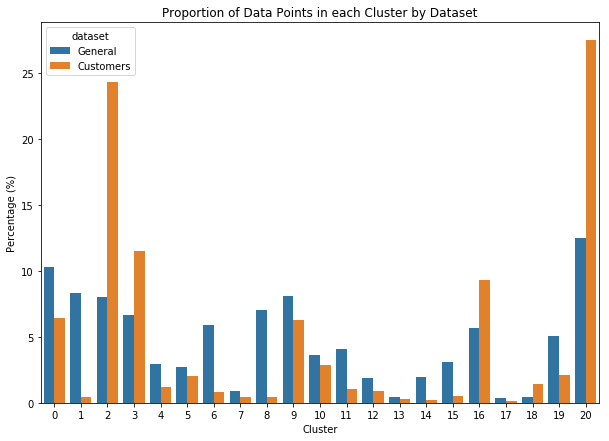

In [334]:
# Plot the proportion of data points in each cluster for each dataset
plt.figure(figsize = (10, 7))
sns.barplot(data = cluster_props, x = 'Cluster', y ='Percentage (%)',  hue = 'dataset')
plt.title('Proportion of Data Points in each Cluster by Dataset')
plt.show()

**In the above plot, the mismatches of the cluster assignment proportions between the two datasets implies that there are only particular segments of the population that are interested in the company's products.  Let's take a closer look at the proportion differences.**

In [335]:
# Pivot to see actual % difference between data sets for every cluster
prop_diff = cluster_props.pivot(index = 'Cluster',  columns = 'dataset', values= 'Percentage (%)')
# Calcualte proportion differences
prop_diff['% Difference'] = prop_diff['Customers'] - prop_diff['General']
prop_diff

dataset,Customers,General,% Difference
Cluster,,,
0,6.399620,10.262101,-3.862481
1,0.460731,8.309387,-7.848656
2,24.255421,8.030107,16.225314
3,11.470269,6.639543,4.830726
4,1.221485,2.959535,-1.738051
5,2.013545,2.730748,-0.717203
6,0.846847,5.911104,-5.064257
7,0.420032,0.910549,-0.490516
8,0.472210,7.038434,-6.566224


In [336]:
# Slightly modified function from clean_data(df) from above.
def drop_data(df):
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
    
    # execute all main cleaning steps:
    # Identify missing or unknown data values and convert them to NaNs.
    for i, column in enumerate(df.columns):
        str_n = feat_info['missing_or_unknown'].iloc[i]
        if i in [57, 58, 59]:  # to accomodate for [*X] unknown values
            list_n = str_n[1: -1].split(',')
        else:
            list_n = literal_eval(str_n)
        for j in list_n:
            df[column].replace(j, np.NaN, inplace = True)

    # Remove the outlier columns from the dataset
    df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1, inplace = True)
            
    # Divide the data into two subsets based on the number of missing values in each row.
    # Using threshold = 10 missing values
    less_missing_df = df[df.isnull().sum(axis = 1) <= 10].reset_index(drop = True)

    # Engineer two new variables, decade and movement, for 'PRAEGENDE_JUGENDJAHRE'
    # For movement:
    #    Mainstream = 1
    #    Avantgarde = 0
    full_mapping = pd.DataFrame({-1: [np.nan, np.nan],
                              0: [np.nan, np.nan],
                              1: [40, 1],
                              2: [40, 0],
                              3: [50, 1],
                              4: [50, 0],
                              5: [60, 1],
                              6: [60, 0],
                              7: [60, 0],
                              8: [70, 1],
                              9: [70, 0],
                              10: [80, 1],
                              11: [80, 0],
                              12: [80, 1],
                              13: [80, 0],
                              14: [90, 1],
                              15: [90, 0]}).T

    # Create column that encodes decade
    decade_mapping = full_mapping[0].to_dict()
    less_missing_df['DECADE'] = less_missing_df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

    # Create column that encodes movement 
    movement_mapping = full_mapping[1].to_dict()
    less_missing_df['MOVEMENT'] = less_missing_df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)

    # Engineer two new variables, wealth and life stage, for 'CAMEO_INTL_2015'
    # We do this by breaking up the two-digit codes by their 'tens'-place and 'ones'-place digits 
    # into two new ordinal variables
    less_missing_df['WEALTH'] = pd.to_numeric(less_missing_df['CAMEO_INTL_2015']) // 10
    less_missing_df['LIFE_STAGE'] = pd.to_numeric(less_missing_df['CAMEO_INTL_2015']) % 10

    # Return the cleaned dataframe.
    return less_missing_df

In [337]:
# Reload datasets and do column/row dropping to use in next part
azdias_fresh = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
customers_fresh = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
azdias1 = drop_data(azdias_fresh)
customers1 = drop_data(customers_fresh)

**First, let's look at what kinds of people are part of a cluster that is *overrepresented* in the customer data compared to the general population.**

In [338]:
# What kinds of people are part of a cluster that is overrepresented in the
#   customer data compared to the general population?

prop_diff['% Difference'].sort_values(ascending = False).head(5)

Cluster
2     16.225314
20    14.974777
3      4.830726
16     3.604083
18     0.997391
Name: % Difference, dtype: float64

**Recall, from the principal component interpretations from step 2.3, a majority of the top positively/negatively weighted features fell into financial and personality-type topologies.  Let's take a look at those features and topologies, as well as some others, for cluster 2.  My findings are under the Discussion section at the end.**

In [339]:
# Looking at cluster 2
overrep = customers_props_df[customers_props_df['Cluster'] == 2].index
overrep_df = customers1.iloc[overrep]
#overrep_df

In [340]:
# Financial typologies from PCA
overrep_df.filter(items=['FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_MINIMALIST', 'FINANZ_HAUSBAUER', 'HH_EINKOMMEN_SCORE', 'LP_STATUS_GROB'])

,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_MINIMALIST,FINANZ_HAUSBAUER,HH_EINKOMMEN_SCORE,LP_STATUS_GROB
2,1,5,5,2,4.0,4.0


In [341]:
# Personality typologies from PCA
overrep_df.filter(items=['SEMIO_REL', 'SEMIO_PFLICHT', 'SEMIO_ERL', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_KULT'])

,SEMIO_REL,SEMIO_PFLICHT,SEMIO_ERL,SEMIO_KAEM,SEMIO_DOM,SEMIO_VERT,SEMIO_SOZ,SEMIO_KULT
2,3,3,3,3,3,7,6,4


In [342]:
# Other features that could be relevant
overrep_df.filter(items=['MOBI_REGIO', 'KBA05_GBZ', 'KBA05_ANTG1', 'ANREDE_KZ', 'ORTSGR_KLS9', 'CAMEO_DEUG_2015', 'ALTERSKATEGORIE_GROB', 'LP_FAMILIE_GROB', 'CJT_GESAMTTYP', 'DECADE', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE'])

,MOBI_REGIO,KBA05_GBZ,KBA05_ANTG1,ANREDE_KZ,ORTSGR_KLS9,CAMEO_DEUG_2015,ALTERSKATEGORIE_GROB,LP_FAMILIE_GROB,CJT_GESAMTTYP,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
2,4.0,4.0,3.0,1,3.0,4,4.0,NaN,2.0,40.0,1.0,2.0,4.0


**Next, let's look at what kinds of people are part of a cluster that is *underrepresented* in the customer data compared to the general population.**

In [343]:
# What kinds of people are part of a cluster that is underrepresented in the
#   customer data compared to the general population?

prop_diff['% Difference'].sort_values(ascending = True).head(5)

Cluster
1    -7.848656
8    -6.566224
6    -5.064257
0    -3.862481
11   -3.025689
Name: % Difference, dtype: float64

**Cluster 1 looks to be the most underepresented (as you can see in the proportion plot as well) so let's take a closer look at the topologies/features for this cluster next.**

In [347]:
# Looking at Cluster 1
underrep = general_props_df[general_props_df['Cluster'] == 1].index
underrep_df = azdias1.iloc[underrep]
#underrep_df

In [348]:
# Financial typologies from PCA
underrep_df.filter(items=['FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_MINIMALIST', 'FINANZ_HAUSBAUER', 'HH_EINKOMMEN_SCORE', 'LP_STATUS_GROB'])

,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_MINIMALIST,FINANZ_HAUSBAUER,HH_EINKOMMEN_SCORE,LP_STATUS_GROB
1,4,1,1,5,4.0,2.0


In [349]:
# Personality typologies from PCA
underrep_df.filter(items=['SEMIO_REL', 'SEMIO_PFLICHT', 'SEMIO_ERL', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_KULT'])

,SEMIO_REL,SEMIO_PFLICHT,SEMIO_ERL,SEMIO_KAEM,SEMIO_DOM,SEMIO_VERT,SEMIO_SOZ,SEMIO_KULT
1,3,3,6,7,7,4,4,3


In [350]:
# Other features that could be relevant
underrep_df.filter(items=['MOBI_REGIO', 'KBA05_GBZ', 'KBA05_ANTG1', 'ANREDE_KZ', 'ORTSGR_KLS9', 'CAMEO_DEUG_2015', 'ALTERSKATEGORIE_GROB', 'LP_FAMILIE_GROB', 'CJT_GESAMTTYP', 'DECADE', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE'])

,MOBI_REGIO,KBA05_GBZ,KBA05_ANTG1,ANREDE_KZ,ORTSGR_KLS9,CAMEO_DEUG_2015,ALTERSKATEGORIE_GROB,LP_FAMILIE_GROB,CJT_GESAMTTYP,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,3.0,3.0,1.0,2,5.0,4,3.0,1.0,3.0,90.0,0.0,2.0,4.0


### Discussion 3.3: Compare Customer Data to Demographics Data

**After considering the proportion of persons in each cluster for the general population, and the proportions for the customers, it's clear (from the proportion plot above) that there are mismatches from one to the other which implies that there are only particular segments of the population that are interested in the company's products.**


**When looking to see what kinds of people that were *overrepresented* in the customer data compared to the general population, the two clusters that showed the highest differences were cluster 2 and cluster 20.** 

* Cluster **20** was the additional cluster that I assigned the dropped rows (n > 10 missing values) from section 1.1.3 since I found that this group was qualitatively different from the main bulk of the data, therefore I treated it as an additional data cluster in this analysis. 

* For cluster **2**, 8% of persons were assigned to a cluster for the general population, but ~24% of the customer data was closest to its centroid, which suggests the people in this cluster are a target audience for the company.  

**From the principal component interpretations from step 2.3, recall that there was a handful of strongly correlated features that represented both financial and personality-based typologies. I examined some of these features (and a few others) from cluster 2 to infer what kind of people might be represented.** 

Using the Data Dictionary to interpret the feature values:
* Financial typologies: very high money saver, very low not prepared, very low low financial interest, very low home ownership, average estimated household net income, houseowner
* Personality (SEMIO_*): more likely to be religious, dutiful, event-oriented, combative, and dominant-minded; not likely to be dreamful or socially-minded, cultural-minded on average
* Movement pattern (MOBI_REGIO): doesn't move often
* Micro-cell (KBA05_GBZ, KBA05_ANTG1): 5-16 buildings, high share of 1-2 family homes in micro-cell
* Estimated age (ALTERSKATEGORIE_GROB): > 60 years old
* Gender (ANREDE_KZ): male
* Preferred information and buying channels for consumer (CJT_GESAMTTYP): Advertising- Consumption traditionalist
* Size of community (ORTSGR_KLS9): 5,001 to  10,000 inhabitants
* Decade: 40s - war years
* Movement: mainstream
* Wealth: consumption-oriented middleclass, prosperous households
* Life stage: older families & mature couples


**In summary, the segments of the population that seem to be relatively popular with the mail-order company appear to be older males (over 60 years of age) that are big money savers (and thus have very low financial interest), and that are in prosperous households.  They are unlikely to move often and are consumption-oriented middleclass. From a personality perspective, they are more likely to be religious, dutiful, and event-oriented (as these characteristics tend to be complementary to one another). Therefore, they are more likely combative/dominant-minded, and not as much socially-minded.**

---

**When looking to see what kinds of people that were *underrepresented* in the customer data compared to the general population, the top cluster was cluster 1.**
* For this cluster, less than 1% of customers closest to the population centroid captured ~8.3% of the data, which suggests that this group of persons is outside of the target demographics.

**I again examined some feature values to infer what kind of people might be represented.** 

Using the Data Dictionary to interpret the feature values:
* Financial typologies: low money saver, very prepared, very high low financial interest, average investor, probably no home ownership, average earner, average estimated household income
* Personality (SEMIO_*): very religious, very dutiful, uncombative, dreamful, socially/cultural-minded, unlikely to be event-oriented and dominant-minded
* Movement pattern (MOBI_REGIO): moves from time to time
* Micro-cell (KBA05_GBZ, KBA05_ANTG1): 17-22 buildings, lower share of 1-2 family homes in micro-cell
* Estimated age (ALTERSKATEGORIE_GROB): 46 - 60 years old
* Gender (ANREDE_KZ): female
* Preferred information and buying channels for consumer (CJT_GESAMTTYP): advertisinginterested Store-shopper
* Size of community (ORTSGR_KLS9): 20,001 to  50,000 inhabitants
* Decade: 90s - ecological awareness
* Movement: avantgarde
* Wealth: consumption-oriented middleclass, prosperous households
* Life stage: single, older families & mature couples

**In summary, the segments of the population that are relatively unpopular with the mail-order company appear to be middle-aged single (typically) females that are average earners and investors, who live in larger communities (but don't necessarily own a house) and who occasionally move from time to time. This audience tends to prefer shopping in-store (which makes sense that they are not in the targeted audience!), and unlike the targeted audience, they are not big money-savers and so have much higher financial interest. Lastly, these individuals tend to be less event-oriented and dominant-minded, and more so socially/cultural-minded and uncombative.**






> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.